# CSI4142 - Group 48 - Assignment 3 - Part 1

---

## Introduction
In this report, we will conduct an empirical study to evaluate a linear regression approach on a regression task. This will be conducted on the ___ daatset. For this study, we will follow the following steps:

1. Clean the data 
2. Encode categorical features to transform them into numerical features 
3. Conduct an EDA (Exploritory Data Analysis) to visualize data and find outliers in the features using LOF (Local Outlier Factor)
4. (Optional) Explore the LinearRegression method suggested in scikit-learn (or other packages)
5. Program a feature aggregator to create 2 additional features
6. Split the data into train, validation, and test sets, choose an evaluation metric (e.g., MSE, RMSE, R²), establish a baseline using linear regression without outlier removal or feature aggregation, perform 4-fold cross-validation on different system variations, select the best model, and evaluate it on the untouched test set.
7. Analyize the results
8. Discuss the outliers and feature aggregation, as well as the results on the unseen test set compare to the cross-validation results


#### Group 48 Members
- Ali Bhangu - 300234254
- Justin Wang - 300234186

<br>

---

## Dataset Descriptions

### Car Detail Dataset

- **Dataset Name:** Vehicle Dataset
- **Author:** Nehal Birla, Nishant Verma, Nikhil Kushwaha (Kaggle)
- **Purpose:** This dataset contains information about used cars. This data can be used for a lot of purposes such as price prediction to exemplify the use of linear regression in Machine Learning.

##### Dataset Shape
- **Rows:** 4339 Rows
- **Columns:** 8 Columns 

#### Features & Descriptions
| Feature Name       | Data Type  | Category    | Description |
|--------------------|------------|-------------|-------------|
| `name`             | String     | Categorical | Name of the cars |
| `year`             | Float      | Numerical   | Year of the car when it was bought |
| `selling_price`    | Float      | Numerical   | Price at which the car is being sold |
| `km_driven`        | Float      | Numerical   | Number of Kilometres the car is driven |
| `fuel`             | String     | Categorical | Fuel type of car (petrol / diesel / CNG / LPG / electric) |
| `seller_type`      | String     | Categorical | Tells if a Seller is Individual or a Dealer |
| `transmission`     | String     | Categorical | Gear transmission of the car (Automatic/Manual) |
| `owner`            | String     | Categorical | Number of previous owners of the car. |

---

In [26]:
# Importing the required Python libraries
import numpy as npy
import pandas as pd
from fuzzywuzzy import fuzz
import os as os
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# Define paths
zip_path = "vehicle-dataset-from-cardekho.zip"
target_csv = "CAR DETAILS FROM CAR DEKHO.csv"  # The only CSV we want to keep
unwanted_csvs = ["car data.csv", "car details v3.csv", "car details v4.csv"]  # Unwanted files

# Remove existing files if present
if os.path.exists(target_csv):
    print(f"Existing {target_csv} found. Deleting and re-extracting...")
    os.remove(target_csv)

# Download dataset using curl (Bash command in Jupyter Notebook)
!curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/nehalbirla/vehicle-dataset-from-cardekho

# Extract the ZIP file in the current folder
print("Extracting dataset...")
!unzip -o {zip_path} -d .

# Delete unwanted CSV files
for file in unwanted_csvs:
    if os.path.exists(file):
        os.remove(file)
        print(f"Deleted unwanted file: {file}")

# Verify that the target CSV exists after extraction
if not os.path.exists(target_csv):
    raise FileNotFoundError(f"Dataset not found: {target_csv}. Ensure the ZIP file was correctly extracted.")

# Load dataset
carSet = pd.read_csv(target_csv)
print("Dataset loaded successfully.")
# carSetTest = carSet.copy()
carSet.head()
carSet.info()


Existing CAR DETAILS FROM CAR DEKHO.csv found. Deleting and re-extracting...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  292k  100  292k    0     0   464k      0 --:--:-- --:--:-- --:--:--  464k
Extracting dataset...
Archive:  vehicle-dataset-from-cardekho.zip
  inflating: ./CAR DETAILS FROM CAR DEKHO.csv  
  inflating: ./Car details v3.csv    
  inflating: ./car data.csv          
  inflating: ./car details v4.csv    
Deleted unwanted file: car data.csv
Deleted unwanted file: car details v3.csv
Deleted unwanted file: car details v4.csv
Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   ob

---
### a) Clean Data

Within this section of our report, we will be cleaning the Car Details dataset. The dataset has no missing values, therefore we have opted in not needing to clean the dataset in regards to missing values. We have decided on verifying the following checks for this dataset:

- Presence Check
- Exact Duplicate Check

As beyond this, the dataset is already clean and ready for regression testing. 

In [5]:
attributes = ["name", "year", "selling_price", "km_driven", "fuel", "owner", "transmission", "seller_type"]
testColumn = attributes[2]

def presence_checker(df, column):
    
    # Checks if the column has any missing values or unknown entries as they exist in the dataset. 
    missing = df[df[column].isna()]
    
    # If there is nothing 
    if missing.empty:
        print(f"The results of the presence checker indicate that there are no missing values found in '{column}'.")
    else:
        # Showcase the results in the dataset. 
        print(f"The results of the presence check are as follows: There are {len(missing)} missing values in '{column}'. \nFor Example:")
        print(missing[[column]].head(len(missing)))  
    
    return missing

# Running the function:
missing_values = presence_checker(carSet, testColumn)

The results of the presence checker indicate that there are no missing values found in 'selling_price'.


In [27]:
carSet.info()

carSetNew = carSet.drop_duplicates(keep="first").reset_index(drop=True)
print("Duplicates removed successfully.")

carSetNew.head() 
carSetNew.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB
Duplicates removed successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577 entries, 0 to 3576
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           3577 non-null   object
 1   year           3577 non-null   int64 
 2   selling_price  3577 non-null   int64 
 3   km_driven      3577 non-null   int64 
 4   fuel      

---
### b) Categorical feature encoding

In [30]:
print(f"Car data : \n{carSetNew.head()}")

categorical_columns = ["transmission", "fuel", "seller_type", "owner", "name"]

#carSet.select_dtypes(include=['object']).columns.tolist()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

one_hot_encoded = encoder.fit_transform(carSetNew[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

car_data_one_hot_encoded = pd.concat([carSetNew, one_hot_df], axis=1)

car_data_one_hot_encoded = car_data_one_hot_encoded.drop(categorical_columns, axis=1)
print(f"Encoded Car data : \n{car_data_one_hot_encoded.head()}")

display(car_data_one_hot_encoded)

encoded_baseline_df = car_data_one_hot_encoded.copy()


Car data : 
                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  
Encoded Car data : 
   year  selling_price  km_driven  transmission_Automatic  \
0  2007          60000      70000                     0.0   
1  2007         135000      50000                     0.0   
2  2012         600000     100000                     0.0   
3  2017         250000      46000      

,year,selling_price,km_driven,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,...,name_Volkswagen Vento Diesel Trendline,name_Volkswagen Vento IPL II Diesel Trendline,name_Volkswagen Vento Magnific 1.6 Highline,name_Volkswagen Vento New Diesel Highline,name_Volkswagen Vento Petrol Highline,name_Volkswagen Vento Petrol Highline AT,name_Volvo V40 D3 R Design,name_Volvo XC 90 D5 Inscription BSIV,name_Volvo XC60 D3 Kinetic,name_Volvo XC60 D5 Inscription
0,2007,60000,70000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007,135000,50000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012,600000,100000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,250000,46000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,450000,141000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,2014,409999,80000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3573,2014,409999,80000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3574,2009,110000,83000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3575,2016,865000,90000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
### c) EDA and Outlier detection

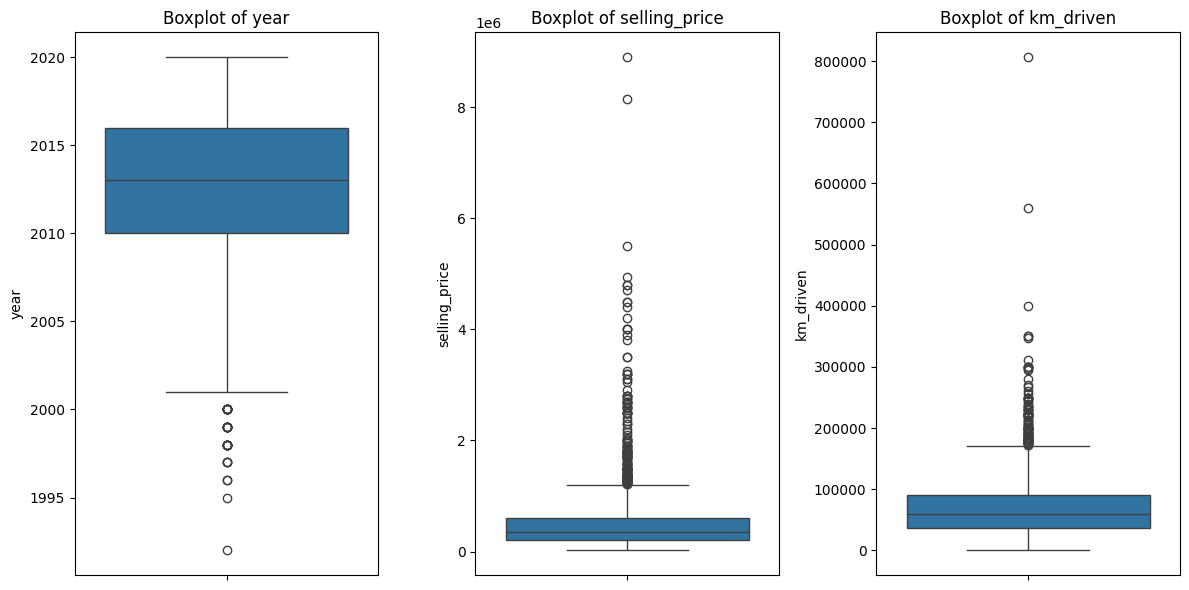

In [31]:
# Visualizing numerical features using boxplots to detect potential outliers
numerical_columns = ["year", "selling_price", "km_driven"]
plt.figure(figsize=(12, 6))

# Creating boxplots for each numerical feature we have
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=car_data_one_hot_encoded[col])
    plt.title(f"Boxplot of {col}")

# Proceeding to display the boxplots
plt.tight_layout()
plt.show()

In [32]:
# Selecting relevant numerical columns for outlier detection
outlier_columns = ["selling_price", "km_driven"]

# Applying LOF to detect outliers via the LOF from Scikit, also assuming 5% outliers. 
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  
outlier_labels = lof.fit_predict(car_data_one_hot_encoded[outlier_columns])

# Identifying outliers (-1 indicates an outlier)
car_data_one_hot_encoded["outlier"] = outlier_labels

display(car_data_one_hot_encoded.tail(20))

# Count of detected outliers
outlier_counts = car_data_one_hot_encoded["outlier"].value_counts()
outlier_counts

print(f"Outlier counts: \n{outlier_counts}")


,year,selling_price,km_driven,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,...,name_Volkswagen Vento IPL II Diesel Trendline,name_Volkswagen Vento Magnific 1.6 Highline,name_Volkswagen Vento New Diesel Highline,name_Volkswagen Vento Petrol Highline,name_Volkswagen Vento Petrol Highline AT,name_Volvo V40 D3 R Design,name_Volvo XC 90 D5 Inscription BSIV,name_Volvo XC60 D3 Kinetic,name_Volvo XC60 D5 Inscription,outlier
3557,2008,114999,66782,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3558,2006,75000,130000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3559,2013,500000,120000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3560,2014,195000,75000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3561,2015,155000,40000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3562,2000,65000,90000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3563,2005,65000,150000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3564,2015,190000,60000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3565,2012,200000,112198,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3566,2010,160000,60000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Outlier counts: 
outlier
 1    3398
-1     179
Name: count, dtype: int64


In [33]:
# Compute mean of 'selling_price' using non-missing data
mean_Price = car_data_one_hot_encoded['selling_price'].mean()

# Replace 'selling_price' with mean_Price where 'outlier' is -1
car_data_one_hot_encoded.loc[car_data_one_hot_encoded['outlier'] == -1, 'selling_price'] = mean_Price

# Print updated DataFrame
print("=== After Imputing Missing 'selling_price' (last few rows) ===")
display(car_data_one_hot_encoded.tail(10))

=== After Imputing Missing 'selling_price' (last few rows) ===


/var/folders/_m/4sf1w9m55kvg_9h80xcfx9_r0000gn/T/ipykernel_1072/2962109971.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '473912.54207436397' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  car_data_one_hot_encoded.loc[car_data_one_hot_encoded['outlier'] == -1, 'selling_price'] = mean_Price


,year,selling_price,km_driven,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,...,name_Volkswagen Vento IPL II Diesel Trendline,name_Volkswagen Vento Magnific 1.6 Highline,name_Volkswagen Vento New Diesel Highline,name_Volkswagen Vento Petrol Highline,name_Volkswagen Vento Petrol Highline AT,name_Volvo V40 D3 R Design,name_Volvo XC 90 D5 Inscription BSIV,name_Volvo XC60 D3 Kinetic,name_Volvo XC60 D5 Inscription,outlier
3567,2010,150000.000000,130000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3568,2015,473912.542074,175000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3569,2015,750000.000000,120000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3570,2012,225000.000000,90000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3571,2012,473912.542074,170000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3572,2014,409999.000000,80000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3573,2014,409999.000000,80000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3574,2009,110000.000000,83000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3575,2016,865000.000000,90000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3576,2016,225000.000000,40000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## d) Linear Regression 

For this section of the assignment, we are utilizing Scikit-Learn's LinearRegression method, we were previously exposed to this in Assignment 2 Part 2, and have opted to re-use it after developing a familiarity. 

In [125]:
# Regression imputation on 'area'

# Train a linear regression model to predict area
reg_model = LinearRegression()

---
## e) Feature Engineering

Feature engineering can be described as creating new features from existing ones to improve prediction accuracy, we have thus decided on the following features: 

1. Car Age -> car_age = 2025 - year 
- This feature will help represent the age of the car in relation to the modern day, which is a strong predictor of its depriciation over time. 
2. Feature Aggregration -> km_per_year = km_driven/ car_age
- This feature provides a look into the cars usage and general wear and tear, year in and year out. 




In [36]:

# Feature Aggregration w/o Outliers
feature_aggregation = encoded_baseline_df.copy()
feature_aggregation["car_age"] = 2025 - feature_aggregation["year"]
feature_aggregation["km_driven_per_year"] = feature_aggregation["km_driven"] // feature_aggregation["car_age"]

# Feature Aggregration w/ Outliers
feature_aggregation_with_outliers = car_data_one_hot_encoded.copy()
feature_aggregation_with_outliers["car_age"] = 2025 - feature_aggregation_with_outliers["year"]
feature_aggregation_with_outliers["km_driven_per_year"] = feature_aggregation_with_outliers["km_driven"] // feature_aggregation_with_outliers["car_age"]


# Displaying the new dataframes we made: 
display(feature_aggregation.head())
display(feature_aggregation_with_outliers.head())

,year,selling_price,km_driven,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,...,name_Volkswagen Vento Magnific 1.6 Highline,name_Volkswagen Vento New Diesel Highline,name_Volkswagen Vento Petrol Highline,name_Volkswagen Vento Petrol Highline AT,name_Volvo V40 D3 R Design,name_Volvo XC 90 D5 Inscription BSIV,name_Volvo XC60 D3 Kinetic,name_Volvo XC60 D5 Inscription,car_age,km_driven_per_year
0,2007,60000,70000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,3888
1,2007,135000,50000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,2777
2,2012,600000,100000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,7692
3,2017,250000,46000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,5750
4,2014,450000,141000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,12818


,year,selling_price,km_driven,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,...,name_Volkswagen Vento New Diesel Highline,name_Volkswagen Vento Petrol Highline,name_Volkswagen Vento Petrol Highline AT,name_Volvo V40 D3 R Design,name_Volvo XC 90 D5 Inscription BSIV,name_Volvo XC60 D3 Kinetic,name_Volvo XC60 D5 Inscription,outlier,car_age,km_driven_per_year
0,2007,60000.0,70000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,18,3888
1,2007,135000.0,50000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,18,2777
2,2012,600000.0,100000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,13,7692
3,2017,250000.0,46000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8,5750
4,2014,450000.0,141000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,11,12818


### f) Empiracal Study 

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def linear_regression_buddy(df, target_column, test_size=0.2, random_state=42, cv_folds=4, label = ""):
    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize Linear Regression model
    regModel = LinearRegression()
    r2_scores = cross_val_score(regModel, X_train, y_train, cv=cv_folds, scoring='r2')

    # Train the model on the full training set
    regModel.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = regModel.predict(X_test)

    # Evaluate R² score on the test set
    r2_test = r2_score(y_test, y_test_pred)

    # Print formatted results
    print("\n ===== Cross-Validation Results - "+label+ " =====")
    print(f"R² Scores for each fold: {r2_scores}")
    print(f"Mean R² Score from {cv_folds}-fold Cross-Validation: {r2_scores.mean():.4f}")

    print("\n ===== Test Set Evaluation - " + label+" =====")
    print(f"R² Score on Test Set: {r2_test:.4f}")

    # Return results as a dictionary
    return {
        "Cross Val R2 Scores": r2_scores,
        "Meaned R2 Scores": r2_scores.mean(),
        "Test R2 Scores": r2_test
    }


In [45]:
# Run Linear Regression on different dataset versions
results_original = linear_regression_buddy(encoded_baseline_df, 'selling_price', label="Baseline Regression Model")
results_outliers_removed = linear_regression_buddy(car_data_one_hot_encoded, 'selling_price', label="Outliers Removed Regression Model")
results_feature_aggregated = linear_regression_buddy(feature_aggregation, 'selling_price', label="Feature Aggregated Regression Model")
results_both = linear_regression_buddy(feature_aggregation_with_outliers, 'selling_price', label="Feature Aggregated with Outliers Regression Model")

# Store all results in a dictionary for comparison
all_results = {
    "Baseline Regression Model": results_original["Meaned R2 Scores"],
    "Outliers Removed Regression Model": results_outliers_removed["Meaned R2 Scores"],
    "Feature Aggregated": results_feature_aggregated["Meaned R2 Scores"],
    "Both Applied": results_both["Meaned R2 Scores"]
}

# Select the best-performing system
best_model = max(all_results, key=all_results.get)
print(f"Best Performing Model: {best_model}")

# Perform final evaluation on the Test Set using the best model
if best_model == "Baseline Regression Model":
    final_results = linear_regression_buddy(encoded_baseline_df, 'selling_price', label = "Final Model Evaluation")
elif best_model == "Outliers Removed Regression Model":
    final_results = linear_regression_buddy(car_data_one_hot_encoded, 'selling_price', label = "Final Model Evaluation")
elif best_model == "Feature Aggregated":
    final_results = linear_regression_buddy(feature_aggregation, 'selling_price', label = "Final Model Evaluation")
elif best_model == "Both Applied":
    final_results = linear_regression_buddy(feature_aggregation_with_outliers, 'selling_price', label = "Final Model Evaluation")


 ===== Cross-Validation Results - Baseline Regression Model =====
R² Scores for each fold: [0.65620643 0.58634978 0.50661361 0.55041819]
Mean R² Score from 4-fold Cross-Validation: 0.5749

 ===== Test Set Evaluation - Baseline Regression Model =====
R² Score on Test Set: 0.5219

 ===== Cross-Validation Results - Outliers Removed Regression Model =====
R² Scores for each fold: [0.66102291 0.50548355 0.62250803 0.55727948]
Mean R² Score from 4-fold Cross-Validation: 0.5866

 ===== Test Set Evaluation - Outliers Removed Regression Model =====
R² Score on Test Set: 0.5697

 ===== Cross-Validation Results - Feature Aggregated Regression Model =====
R² Scores for each fold: [0.65478848 0.58521858 0.50580141 0.55049745]
Mean R² Score from 4-fold Cross-Validation: 0.5741

 ===== Test Set Evaluation - Feature Aggregated Regression Model =====
R² Score on Test Set: 0.5222

 ===== Cross-Validation Results - Feature Aggregated with Outliers Regression Model =====
R² Scores for each fold: [0.66139

---
## Result Analysis
### a. Analyzing the Obtained Results

We ran a total of four regression models, with the first being used on the baseline linear regression model, then using the modified dataframe with Outliers removed and Mean Imputation, then the baseline dataset using feature aggregration and lastly the modified dataframe with Outliers and Mean Imputation + Feature Aggregration. 


- The baseline linear regression model achieved a mean R² score of 0.5749 during 4-fold cross-validation and an R² score of 0.5219 on the test set. Various preprocessing techniques, such as outlier removal and feature aggregation, were applied to assess their impact on model performance.

- Outlier removal improved both cross-validation and test set performance, increasing the mean cross-validation R² score from 0.5749 to 0.5866 and the test R² score from 0.5219 to 0.5697.

- Feature aggregation alone had minimal effect, with a slight decline in cross-validation performance (0.5741) and a near-identical test R² score (0.5222).

- Combining outlier removal with feature aggregation did not yield significant additional improvement compared to just outlier removal alone, achieving 0.5862 on cross-validation and 0.5724 on the test set.

The best-performing model was the outlier-removed regression model, which was then used for final evaluation.

#### b. Impact of Outlier Detection and Feature Aggregation
Outlier removal had a positive impact on the model, improving performance on both cross-validation and the test set. Removing extreme values likely reduced noise and made the regression model better at capturing patterns in the data.

Feature aggregation, on the other hand, did not lead to noticeable improvements. This suggests that the existing feature set already contained sufficient information, and aggregating features may not have introduced additional predictive power. Moreover, if feature aggregation led to a loss of useful information, it could explain the slightly lower performance observed.

When both techniques were applied together, the results were comparable to using only outlier removal, indicating that feature aggregation did not contribute much additional value beyond what was gained from handling outliers.

#### c. Comparison of Test Set and Cross-Validation Results
The results on the unseen test set were generally lower than the mean cross-validation scores, which is expected due to:

Overfitting to the training data during cross-validation, where multiple models were trained and validated on different subsets. A potentially different distribution of data in the test set, leading to a slight performance drop when generalizing to completely unseen data. However, the performance gap between cross-validation and test set results was not drastic, indicating that the model was able to generalize fairly well. The final model selection based on cross-validation results aligned well with test set performance, confirming that outlier removal was beneficial for improving the model’s robustness.



---
## Conclusion 

Outlier removal provided the best improvements in both cross-validation and test performance, leading to the selection of the Outliers Removed Regression Model for final evaluation. Feature aggregation, on the other hand, had negligible impact. The test set performance remained consistent with the cross-validation trends, reinforcing the reliability of the chosen model.

Overall, this project has taught us the importance and benefit of outlier removal and feature aggregration. This led to strengthining our skills in Data Science & Python Programming. 